In [1]:
## Technologies
# CUDA toolkit 10.0
# Tensorflow-gpu 2.0
# cuDNN 7.6.4

In [2]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from math import ceil
import tensorflow as tf
from PIL import Image, ImageFile

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6040)

VirtualDeviceConfiguration(memory_limit=6040)

In [4]:
#map betweem image names and labels 
matData = loadmat('./cars_annos.mat')

labelsList = []
for arr in matData['annotations'][0]:
    imgPath = arr[0][0]
    labelNum = arr[5][0][0]
    splitTag = arr[6][0][0]
    labelsList.append([imgPath, labelNum, splitTag])
print("img nummber: ", len(labelsList))

labelNameDict = {}
labelList = []
for i,arr in enumerate(matData['class_names'][0]):
    labelName = arr[0]
    labelNameDict[i+1] = labelName
    labelList.append(labelName)
print("label number: ", len(labelNameDict))

labelsDF = pd.DataFrame(labelsList, columns=['imgPath', 'label', 'testTag'])
labelsDF['label'] = labelsDF['label'].map(labelNameDict)
labelsDF.tail(10)

img nummber:  16185
label number:  196


,imgPath,label,testTag
16175,car_ims/016176.jpg,smart fortwo Convertible 2012,1
16176,car_ims/016177.jpg,smart fortwo Convertible 2012,1
16177,car_ims/016178.jpg,smart fortwo Convertible 2012,1
16178,car_ims/016179.jpg,smart fortwo Convertible 2012,1
16179,car_ims/016180.jpg,smart fortwo Convertible 2012,1
16180,car_ims/016181.jpg,smart fortwo Convertible 2012,1
16181,car_ims/016182.jpg,smart fortwo Convertible 2012,1
16182,car_ims/016183.jpg,smart fortwo Convertible 2012,1
16183,car_ims/016184.jpg,smart fortwo Convertible 2012,1
16184,car_ims/016185.jpg,smart fortwo Convertible 2012,1


In [5]:
#split train and test
trainDF = labelsDF[labelsDF['testTag']==0]
print("amount of train set:", len(trainDF))
testDF = labelsDF[labelsDF['testTag']==1]
print("amount of test set:", len(testDF))
validationDF = testDF.sample(n=1000)
print("amount of validationDF:", len(validationDF))

amount of train set: 8144
amount of test set: 8041
amount of validationDF: 1000


In [6]:
#model parms
classNum = len(labelNameDict)
classContent = labelList

In [7]:
#base model
base_model = tf.keras.applications.resnet.ResNet50(weights='resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)

In [8]:
#add top layer
top = base_model.output
top = tf.keras.layers.GlobalAveragePooling2D()(top)
top = tf.keras.layers.Flatten()(top)
top = tf.keras.layers.Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(top)
top = tf.keras.layers.BatchNormalization()(top)
top = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(top)
top = tf.keras.layers.BatchNormalization(name='bn_fc_01')(top)
top_model = tf.keras.layers.Dense(classNum, activation='softmax')(top)

In [9]:
# learning rate
# adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [10]:
#create model
model = tf.keras.models.Model(inputs=base_model.input, outputs=top_model)
for layer in base_model.layers[:30]:
    layer.trainable = False

In [11]:
#model load
#model = tf.keras.models.load_model('models/3/car.15-0.17.hdf5')

In [12]:
#model config
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['acc'])

In [13]:
#call back functions
early_stop = tf.keras.callbacks.EarlyStopping('loss', patience=5)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('./models/car.{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau('loss', factor=0.1, patience=1)
callbacks = [early_stop, model_checkpoint, reduce_lr]

In [14]:
#data preprocess parms
img_width, img_height = 224, 224
batch_size = 10
epochs = 100
trainNum = len(trainDF)
validNum = len(validationDF)

In [15]:
#input data preprocess
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True
)
train_generator = train_datagen.flow_from_dataframe(
    #trainDF.sample(n=trainNum),
    trainDF,
    target_size = (img_width, img_height),
    x_col = 'imgPath',
    y_col = 'label',
    classes = classContent,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 8144 validated image filenames belonging to 196 classes.


In [16]:
#valid data preprocess
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
valid_generator = valid_datagen.flow_from_dataframe(
    validationDF,
    target_size = (img_width, img_height),
    x_col = 'imgPath',
    y_col = 'label',
    classes = classContent,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 1000 validated image filenames belonging to 196 classes.


In [17]:
#train model
model_history = model.fit_generator(
    train_generator,
    steps_per_epoch = ceil(trainNum / batch_size),
    validation_data = valid_generator,
    validation_steps = ceil(validNum / batch_size),
    epochs = epochs,
    callbacks = callbacks,
    verbose=1
)

Epoch 1/100
814/815 [============================>.] - ETA: 0s - loss: 8.5001 - acc: 0.0045
Epoch 00001: val_acc improved from -inf to 0.00400, saving model to ./models/car.01-0.00.hdf5
815/815 [==============================] - 322s 395ms/step - loss: 8.4976 - acc: 0.0045 - val_loss: 7.8909 - val_acc: 0.0040
Epoch 2/100
814/815 [============================>.] - ETA: 0s - loss: 6.3594 - acc: 0.0053
Epoch 00002: val_acc improved from 0.00400 to 0.01000, saving model to ./models/car.02-0.01.hdf5
815/815 [==============================] - 307s 377ms/step - loss: 6.3593 - acc: 0.0053 - val_loss: 8.7717 - val_acc: 0.0100
Epoch 3/100
814/815 [============================>.] - ETA: 0s - loss: 6.2980 - acc: 0.0047
Epoch 00003: val_acc did not improve from 0.01000
815/815 [==============================] - 301s 369ms/step - loss: 6.2978 - acc: 0.0047 - val_loss: 7.4588 - val_acc: 0.0050
Epoch 4/100
814/815 [============================>.] - ETA: 0s - loss: 6.2094 - acc: 0.0052
Epoch 00004: val

In [19]:
import matplotlib.pyplot as plt

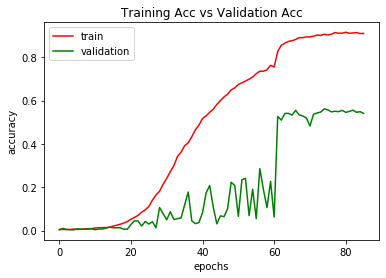

In [23]:
plt.figure(0)
plt.plot(model_history.history['acc'],'r')
plt.plot(model_history.history['val_acc'],'g')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training Acc vs Validation Acc")
plt.legend(["train", "validation"])

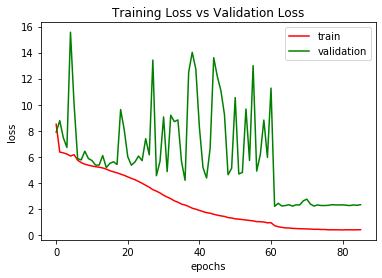

In [24]:
plt.figure(1)
plt.plot(model_history.history['loss'],'r')
plt.plot(model_history.history['val_loss'],'g')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(["train", "validation"])